In [1]:
from pandas import read_csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import networkx as nx
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator
from IPython.core.display import display, HTML
from pgmpy.independencies.Independencies import IndependenceAssertion
from pgmpy.inference import VariableElimination
from sklearn.preprocessing import LabelEncoder

df = read_csv("heart.csv")
df.head()

C:\Users\Kankana Ghosh\AppData\Local\Programs\Python\Python310\lib\site-packages\pgmpy\global_vars.py:11: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:77.)
  device = torch.device("cpu")
C:\Users\Kankana Ghosh\AppData\Local\Temp\ipykernel_5224\445524174.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [2]:
df.shape

(303, 14)

age : Age of the patient

sex : Sex of the patient
      
    Value 0 : Female
      
    Value 1: Male

ChestPainType : Chest Pain type

    Value 0: typical angina

    Value 1: atypical angina

    Value 2: non-anginal pain

    Value 3: asymptomatic

RestingBP : resting blood pressure (in mm Hg)

Cholestrol: cholesterol in mg/dl fetched via BMI sensor

FastingBS: (fasting blood sugar > 120 mg/dl)

    1 = true

    0 = false

Resting_ECG: resting electrocardiographic results

    Value 0: normal

    Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)

    Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

MaxHR: maximum heart rate achieved

ExerciseAngina: exercise induced angina

    1 = yes

    0 = no

oldpeak: ST depression induced by exercise relative to rest

ST_slope: the slope of the peak exercise ST segment

    0 = unsloping

    1 = flat

    2 = downsloping

no.ofVes: number of major vessels (0-3)

Thalassemia

    0 = null

    1 = fixed defect

    2 = normal

    3 = reversable defect

HeartAttack: diagnosis of heart disease (angiographic disease status)

    0: < 50% diameter narrowing. less chance of heart disease

    1: > 50% diameter narrowing. more chance of heart disease

Renaming the column names for better understanding

In [3]:
df.rename(
    columns=({ 'cp': 'ChestPainType', 'trtbps': 'RestingBP', 'chol':'Cholestrol', 'fbs': 'FastingBS', 'restecg':'RestingECG','thalachh':'MaxHR','exng':'ExerciseAngina','slp':'ST_Slope','caa': 'no.ofVes','thall' : 'Thalassemia','output':'HeartAttack'}), 
    inplace=True,
)
df.head()

,age,sex,ChestPainType,RestingBP,Cholestrol,FastingBS,RestingECG,MaxHR,ExerciseAngina,oldpeak,ST_Slope,no.ofVes,Thalassemia,HeartAttack
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Setting target variable

In [4]:
target='HeartAttack'

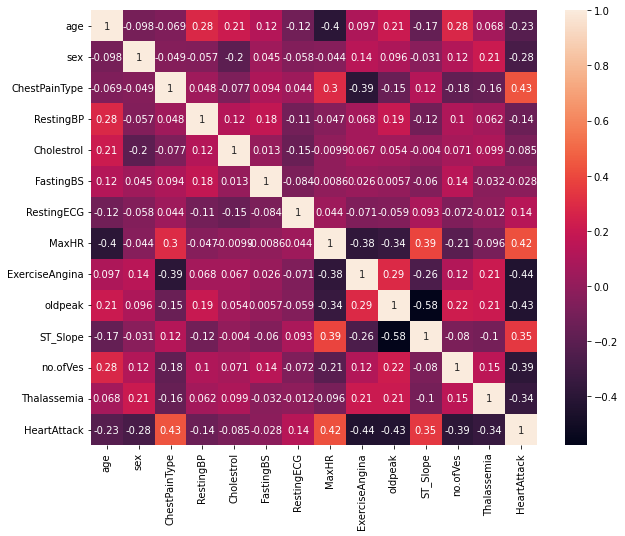

In [5]:
# correlation matrix of each feature with respect to target

corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True)
plt.show()

Data discretization

Pgmpy doesn't support learning parameters from continuous variables (https://github.com/pgmpy/pgmpy/issues/1084). In particular only relevant bins were taken into consideration.

In [6]:
df['age']=pd.cut(x=df['age'], bins=[np.min(df['age']),35,45,55,65,75,np.max(df['age'])], 
                        labels=["25-35","35-45","45-55","55-65", "65-75", "75-85"])

https://www.cdc.gov/bloodpressure/about.htm#:~:text=%2F80%20mmHg.%E2%80%9D-,What%20are%20normal%20blood%20pressure%20numbers%3F,less%20than%20120%2F80%20mmHg.&text=No%20matter%20your%20age%2C%20you,pressure%20in%20a%20healthy%20range.

In [7]:
df['RestingBP']=pd.cut(x=df['RestingBP'], bins=[np.min(df['RestingBP']),110,130,np.max(df['RestingBP'])], 
                        labels=["90-110","110-130","130+"])

In [8]:
df['Cholestrol']=pd.cut(x=df['Cholestrol'], bins=[np.min(df['Cholestrol']),200,240,280,320,np.max(df['Cholestrol'])], 
                        labels=["120-200","200-240","240-280","280-320","320+"])

In [9]:
df['MaxHR']=pd.cut(x=df['MaxHR'], bins=[np.min(df['MaxHR']),99,132,160,np.max(df['MaxHR'])], 
                        labels=["70-99","99-130","130-160","160-205"])

In [10]:
df['oldpeak']=pd.cut(x=df['oldpeak'], bins=[np.min(df['oldpeak']),1.5,2.5,np.max(df['oldpeak'])], 
                        labels=["0-1.5","1.5-2.5","2.5-6"])

In [11]:
df.head()

,age,sex,ChestPainType,RestingBP,Cholestrol,FastingBS,RestingECG,MaxHR,ExerciseAngina,oldpeak,ST_Slope,no.ofVes,Thalassemia,HeartAttack
0,55-65,1,3,130+,200-240,1,0,130-160,0,1.5-2.5,0,0,1,1
1,35-45,1,2,110-130,240-280,0,1,160-205,0,2.5-6,0,0,2,1
2,35-45,0,1,110-130,200-240,0,0,160-205,0,0-1.5,2,0,2,1
3,55-65,1,1,110-130,200-240,0,1,160-205,0,0-1.5,2,0,2,1
4,55-65,0,0,110-130,320+,0,1,160-205,1,0-1.5,2,0,2,1


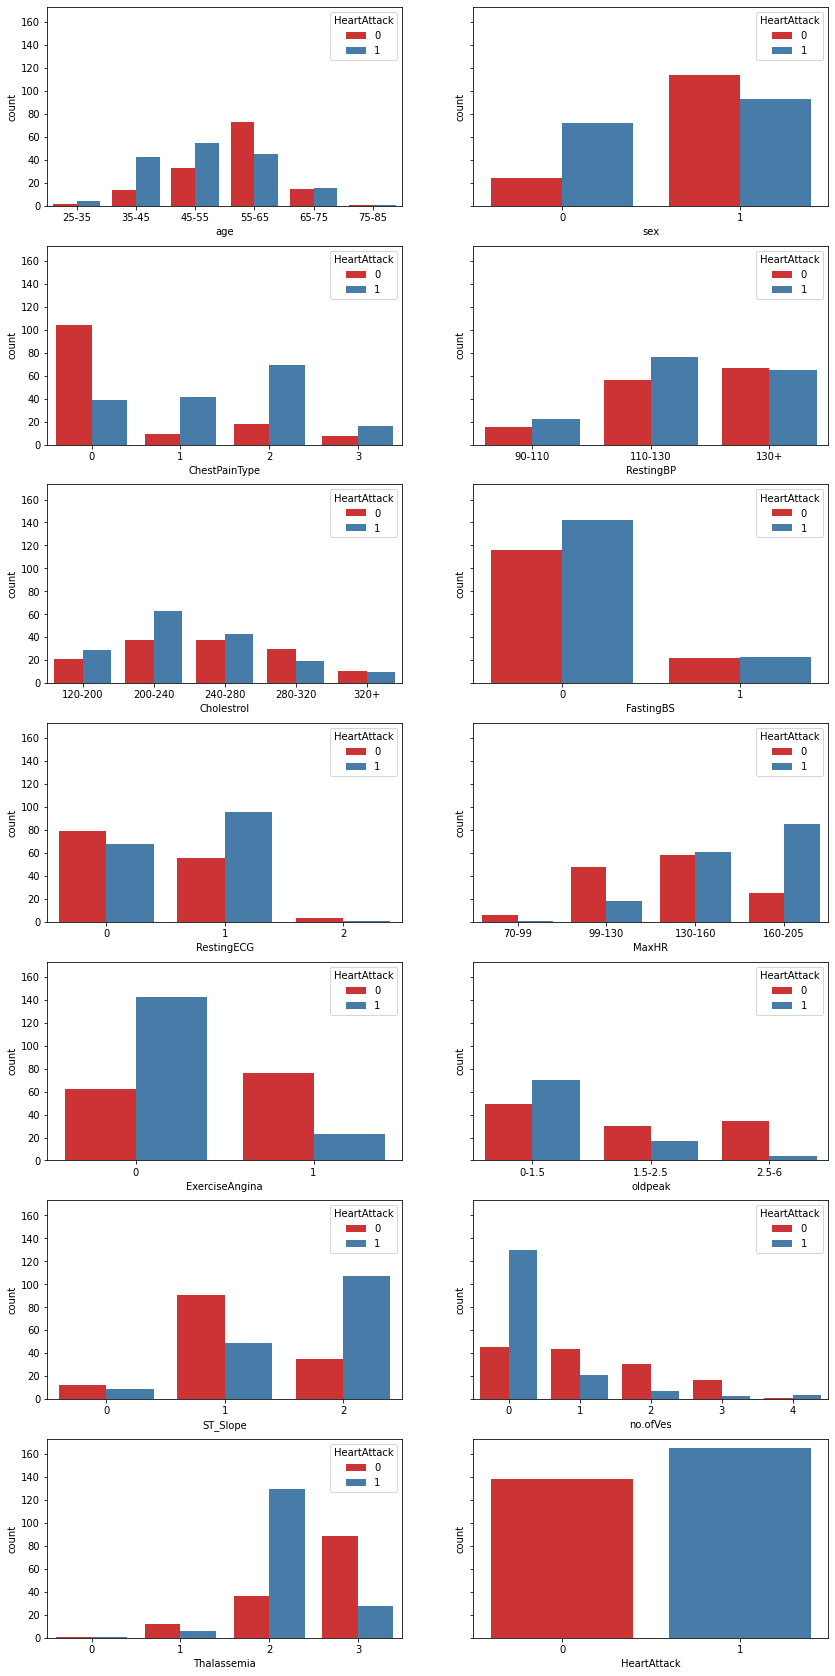

In [12]:
# countplot of each feature with respect to target "HeartAttack"

_, axes = plt.subplots(nrows=7, ncols=2, figsize=(14, 30), sharey=True)
axes = [axis for subl in axes for axis in subl]
for col, ax in zip(df.columns, axes):
    if col != target:
        sns.countplot(x=col, hue="HeartAttack", data=df, ax=ax, palette="Set1")
    else:
        sns.countplot(x=col, data=df, ax=ax, palette="Set1")

### Bayesian Model and CPT
Before calulating the CPT,we need to create the bayesian Model and need to create the connections between the nodes. The connection between the nodes are based on various scientific medical publications and online resources. The node connections are as follows :

age -> RestingBP https://www.nia.nih.gov/health/heart-health-and-aging#:~:text=The%20most%20common%20aging%20change,more%20common%20as%20we%20age.

age -> maxHR https://www.tampaveinspecialists.com/changes-in-max-heart-rate-with-aging/#:~:text=As%20we%20get%20older%2C%20our,maximum%20heart%20rate%20(MHR).

age -> cholestrol https://www.healthline.com/health/high-cholesterol/levels-by-age#:~:text=As%20we%20age%2C%20cholesterol%20levels,more%20frequent%20testing%20is%20recommended.

sex -> cholestrol https://www.healthline.com/health/high-cholesterol/levels-by-age#:~:text=As%20we%20age%2C%20cholesterol%20levels,more%20frequent%20testing%20is%20recommended.

sex -> RestingBP https://www.ahajournals.org/doi/full/10.1161/01.HYP.37.5.1199#:~:text=Recent%20studies%20using%20the%20technique,even%20higher%20than%20in%20men.

sex -> maxHR https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4190707/#:~:text=The%20average%20adult%20male%20heart,smaller%20in%20females%20than%20males.

RestingBP-> ChestPainType https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6749909/
Cholestrol-> ChestPainTYpe https://www.mayoclinic.org/diseases-conditions/high-blood-cholesterol/symptoms-causes/syc-20350800#:~:text=High%20cholesterol%20can%20cause%20a,Chest%20pain.

Cholestrol-> RestingBP https://www.healthline.com/health/high-cholesterol/treating-with-statins/hypertension#6
FastingBS-> Cholestrol https://www.healthline.com/health/diabetes/cholesterol-and-glucose-metabolism
RestingBP-> MaxHR https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3491126/#:~:text=Elevated%20heart%20rate%20is%20associated,consideration%20in%20choosing%20antihypertensive%20medications.
Cholestrol-> MaxHR https://goforward.com/blog/heart-health/how-does-high-cholesterol-affect-the-heart#:~:text=Does%20high%20cholesterol%20affect%20heart,oxygen%2Drich%20blood%20through%20them.

Thalassemia -> FastingBS https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3598161/

Thalassamia -> MaxHR https://www.webmd.com/a-to-z-guides/beta-thalassemia-complications#:~:text=a%20serious%20infection.-,Heart%20Problems,can%27t%20pump%20enough%20blood

Thalassemia -> ExerciseAngina https://www.ncbi.nlm.nih.gov/books/NBK173957/
 
no.ofVes -> RestingBP https://my.clevelandclinic.org/health/diseases/23352-vasodilation#:~:text=What%20is%20vasodilation%3F-,Vasodilation%20is%20the%20medical%20term%20for%20when%20blood%20vessels%20in,without%20you%20even%20realizing%20it.

Thalassemia -> Cholestrol https://pubmed.ncbi.nlm.nih.gov/21710812/#:~:text=The%20amount%20of%20serum%20total,groups%20did%20not%20show%20any

Cholestrol -> HeartAttack https://familyheart.org/truth-cholesterol-heart-disease#:~:text=When%20there%20is%20too%20much%20cholesterol%20in%20your%20blood%2C%20it,off%20a%20heart%20attack%20results.

MaxHR -> ExerciseAngina https://my.clevelandclinic.org/health/diseases/21489-angina#:~:text=Angina%20is%20chest%20pain%20or,blood%2C%20causing%20you%20noticeable%20pain.

oldpeak -> ST_slope https://pubmed.ncbi.nlm.nih.gov/31144537/

oldpeak -> ExerciseAngina https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1768611/

oldpeak -> restECG https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1768611/

ChestPainType -> HeartAttack https://www.bhf.org.uk/informationsupport/heart-matters-magazine/medical/angina-common-questions#:~:text=Most%20people%20who%20are%20diagnosed,to%20have%20a%20heart%20attack.

RestingBP -> HeartAttack https://nortonhealthcare.com/news/whats-the-link-between-a-heart-attack-and-blood-pressure/#:~:text=High%20blood%20pressure%20can%20cause,of%20heart%20attacks%20and%20stroke.&text=High%20blood%20pressure%20puts%20extra%20strain%20on%20the%20heart%20and%20arteries.

In [13]:
model=BayesianNetwork([('age', 'RestingBP'),('age', 'MaxHR'),('age', 'Cholestrol'),
                       ('sex', 'Cholestrol'),('sex','MaxHR'),('sex','RestingBP'),
                       ('Cholestrol', 'ChestPainType'),('Cholestrol', 'RestingBP'),('Cholestrol', 'MaxHR'),
                       ('FastingBS', 'Cholestrol'),
                       ('RestingBP', 'MaxHR'),('RestingBP', 'ChestPainType'),
                       ('Thalassemia', 'FastingBS'),('Thalassemia', 'MaxHR'),('Thalassemia', 'ExerciseAngina'),('Thalassemia', 'Cholestrol'),
                       ('no.ofVes', 'RestingBP'),('MaxHR', 'ExerciseAngina'),
                       ('oldpeak', 'ST_Slope'),('oldpeak', 'ExerciseAngina'),('oldpeak', 'RestingECG'),
                       ('Cholestrol', 'HeartAttack'),('ChestPainType', 'HeartAttack'),('RestingBP', 'HeartAttack')])
#columns=({ 'cp': 'ChestPainType', 'trtbps': 'RestingBP', 'chol':'Cholestrol', 'fbs': 'FastingBS', 'restecg':'RestingECG','thalachh':'MaxHR','exng':'ExerciseAngina','slp':'ST_Slope','caa': 'no.ofVes','thall' : 'Thalassemia','output':'HeartAttack'}), 

Showing all the Nodes of the Model

In [14]:
print('Nodes',model.nodes(),'\n')

Nodes ['age', 'RestingBP', 'MaxHR', 'Cholestrol', 'sex', 'ChestPainType', 'FastingBS', 'Thalassemia', 'ExerciseAngina', 'no.ofVes', 'oldpeak', 'ST_Slope', 'RestingECG', 'HeartAttack'] 



Showing all the Edges of the model

In [15]:
print('Edges',model.edges())

Edges [('age', 'RestingBP'), ('age', 'MaxHR'), ('age', 'Cholestrol'), ('RestingBP', 'MaxHR'), ('RestingBP', 'ChestPainType'), ('RestingBP', 'HeartAttack'), ('MaxHR', 'ExerciseAngina'), ('Cholestrol', 'ChestPainType'), ('Cholestrol', 'RestingBP'), ('Cholestrol', 'MaxHR'), ('Cholestrol', 'HeartAttack'), ('sex', 'Cholestrol'), ('sex', 'MaxHR'), ('sex', 'RestingBP'), ('ChestPainType', 'HeartAttack'), ('FastingBS', 'Cholestrol'), ('Thalassemia', 'FastingBS'), ('Thalassemia', 'MaxHR'), ('Thalassemia', 'ExerciseAngina'), ('Thalassemia', 'Cholestrol'), ('no.ofVes', 'RestingBP'), ('oldpeak', 'ST_Slope'), ('oldpeak', 'ExerciseAngina'), ('oldpeak', 'RestingECG')]


### Model Diagram

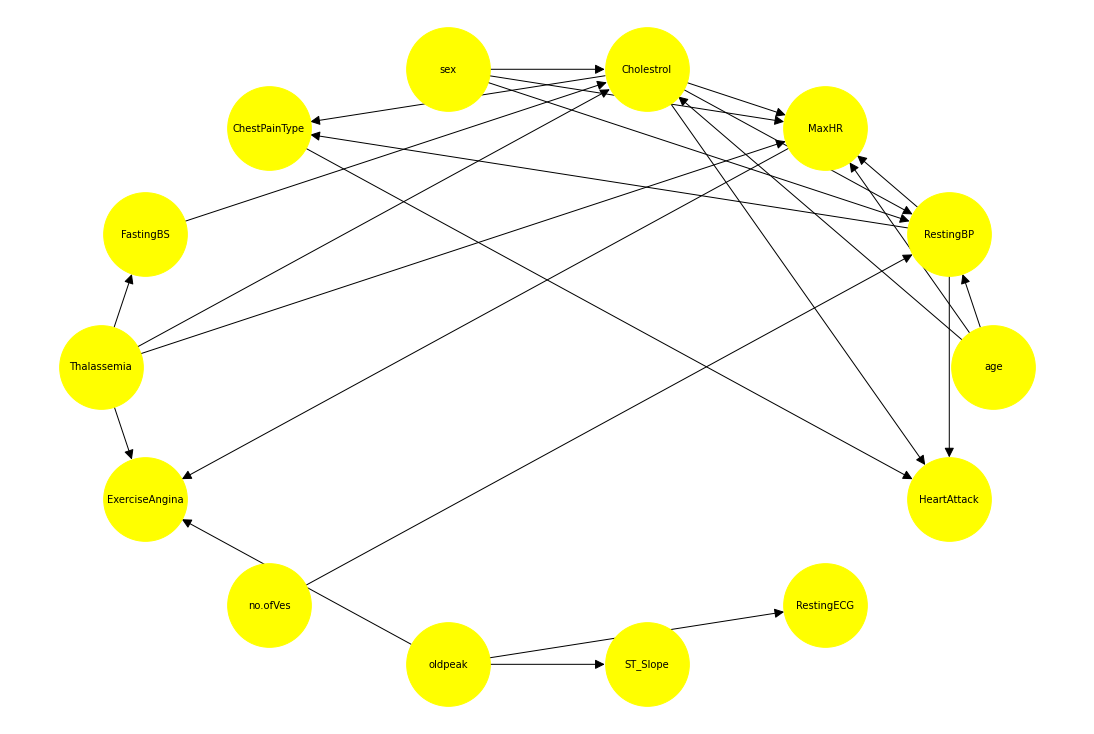

In [16]:
plt.figure(figsize=(15,10))
nx.draw_circular(model, with_labels=True, arrowsize=20, node_size=7000, font_size=10,node_color='yellow')
plt.show()

### CPT

The CPT is learned, by Estimator, taking into consideration about pros and cons of the estimator, instead of a Maximum Likelihood Estimator, chosing the Bayesian Estimator as it’s more robust. Pgmpy also offer a variety of possible priors, among them a possible choice is Bayesian Dirichlet equivalent uniform prior (BDeu), chosen with its equivalent_sample_size equal to 10. Then the CPT are displayed.

In [17]:
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

model.cpds = []
model.fit(data=df,
          estimator=BayesianEstimator,
          prior_type="BDeu",
          equivalent_sample_size=10,
          complete_samples_only=False)

print(f'Check model: {model.check_model()}\n')
for cpd in model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')

Check model: True

CPT of age:
+------------+-----------+
| age(25-35) | 0.0245726 |
+------------+-----------+
| age(35-45) | 0.188034  |
+------------+-----------+
| age(45-55) | 0.287393  |
+------------+-----------+
| age(55-65) | 0.383547  |
+------------+-----------+
| age(65-75) | 0.104701  |
+------------+-----------+
| age(75-85) | 0.0117521 |
+------------+-----------+ 

CPT of RestingBP:
+--------------------+----------------------+-----+---------------------+---------------------+
| Cholestrol         | Cholestrol(120-200)  | ... | Cholestrol(320+)    | Cholestrol(320+)    |
+--------------------+----------------------+-----+---------------------+---------------------+
| age                | age(25-35)           | ... | age(75-85)          | age(75-85)          |
+--------------------+----------------------+-----+---------------------+---------------------+
| no.ofVes           | no.ofVes(0)          | ... | no.ofVes(4)         | no.ofVes(4)         |
+--------------------+

### Network Analysis

#### Independence and Decendents

Using method ‘local_independencies()’ and 'model.get_children()' from pgmpy to get the local independencies and decendants of each node.

In [18]:
for i in model.nodes():
  print(" Independencies :",i,'\n',model.local_independencies(i))
  print(" Descendants :",i,'\n',model.get_children(i))
  print('\n')

 Independencies : age 
 (age ⟂ Thalassemia, FastingBS, oldpeak, ST_Slope, no.ofVes, RestingECG, sex)
 Descendants : age 
 ['RestingBP', 'MaxHR', 'Cholestrol']


 Independencies : RestingBP 
 (RestingBP ⟂ Thalassemia, oldpeak, ST_Slope, FastingBS, RestingECG | Cholestrol, age, no.ofVes, sex)
 Descendants : RestingBP 
 ['MaxHR', 'ChestPainType', 'HeartAttack']


 Independencies : MaxHR 
 (MaxHR ⟂ HeartAttack, ChestPainType, FastingBS, oldpeak, ST_Slope, no.ofVes, RestingECG | Thalassemia, age, RestingBP, Cholestrol, sex)
 Descendants : MaxHR 
 ['ExerciseAngina']


 Independencies : Cholestrol 
 (Cholestrol ⟂ oldpeak, no.ofVes, RestingECG, ST_Slope | Thalassemia, age, FastingBS, sex)
 Descendants : Cholestrol 
 ['ChestPainType', 'RestingBP', 'MaxHR', 'HeartAttack']


 Independencies : sex 
 (sex ⟂ Thalassemia, FastingBS, oldpeak, age, ST_Slope, no.ofVes, RestingECG)
 Descendants : sex 
 ['Cholestrol', 'MaxHR', 'RestingBP']


 Independencies : ChestPainType 
 (ChestPainType ⟂ sex, ST_Slope

### Markov Blanket and Active Trails

In pgmpy it’s possible to investigate different properties of the network. 
Implementing the functions ‘markov blanket()’ , which returns the set of node’s parents, its children and its children’s other parents and ‘active_trails_of()’, which returns all the nodes reachable from start via an active trail.

In [19]:
# the markov blanket of each node
for i in model.nodes():
  print("Markov Blanket: ",i,'\n',model.get_markov_blanket(i))
  print('\n')

Markov Blanket:  age 
 ['MaxHR', 'no.ofVes', 'FastingBS', 'Thalassemia', 'RestingBP', 'Cholestrol', 'sex']


Markov Blanket:  RestingBP 
 ['HeartAttack', 'MaxHR', 'no.ofVes', 'Thalassemia', 'ChestPainType', 'age', 'Cholestrol', 'sex']


Markov Blanket:  MaxHR 
 ['ExerciseAngina', 'Thalassemia', 'oldpeak', 'age', 'RestingBP', 'Cholestrol', 'sex']


Markov Blanket:  Cholestrol 
 ['HeartAttack', 'MaxHR', 'FastingBS', 'no.ofVes', 'Thalassemia', 'ChestPainType', 'age', 'RestingBP', 'sex']


Markov Blanket:  sex 
 ['MaxHR', 'FastingBS', 'no.ofVes', 'Thalassemia', 'age', 'RestingBP', 'Cholestrol']


Markov Blanket:  ChestPainType 
 ['HeartAttack', 'RestingBP', 'Cholestrol']


Markov Blanket:  FastingBS 
 ['Thalassemia', 'age', 'Cholestrol', 'sex']


Markov Blanket:  Thalassemia 
 ['sex', 'FastingBS', 'MaxHR', 'oldpeak', 'age', 'RestingBP', 'Cholestrol', 'ExerciseAngina']


Markov Blanket:  ExerciseAngina 
 ['Thalassemia', 'oldpeak', 'MaxHR']


Markov Blanket:  no.ofVes 
 ['age', 'RestingBP', 

In [20]:
# the active trails between variables with/without evidence
def active_trails_of(query, evidence):
    a = model.active_trail_nodes(query, observed=evidence).get(query)
    a.remove(query)
    if a:
        if evidence:
            print(f'Active trails between \'{query}\' and {a} given the evidence {set(evidence)}.')
        else:
            print(f'Active trails between \'{query}\' and {a} given no evidence.')
    else:
        print(f'No Active trails for \'{query}\' given the evidence {set(evidence)}.')

active_trails_of(query='HeartAttack', evidence=[])
active_trails_of(query='HeartAttack', evidence=['RestingBP'])
active_trails_of(query='HeartAttack', evidence=['Cholestrol','Thalassemia'])
active_trails_of(query='RestingBP', evidence=['Cholestrol','age'])
active_trails_of(query='Cholestrol', evidence=[])

# Checking d-separation between variables without evidence
print("RestingBP and HeartAttack is_dconnected : ",model.is_dconnected("RestingBP","HeartAttack"))
#print('Active trails between ',model.active_trail_nodes('ExerciseAngina'))

Active trails between 'HeartAttack' and {'sex', 'MaxHR', 'FastingBS', 'no.ofVes', 'Thalassemia', 'ChestPainType', 'age', 'RestingBP', 'Cholestrol', 'ExerciseAngina'} given no evidence.
Active trails between 'HeartAttack' and {'sex', 'MaxHR', 'FastingBS', 'no.ofVes', 'Thalassemia', 'ChestPainType', 'age', 'Cholestrol', 'ExerciseAngina'} given the evidence {'RestingBP'}.
Active trails between 'HeartAttack' and {'ExerciseAngina', 'no.ofVes', 'MaxHR', 'FastingBS', 'ChestPainType', 'age', 'RestingBP', 'sex'} given the evidence {'Thalassemia', 'Cholestrol'}.
Active trails between 'RestingBP' and {'HeartAttack', 'ExerciseAngina', 'no.ofVes', 'MaxHR', 'FastingBS', 'Thalassemia', 'ChestPainType', 'sex'} given the evidence {'age', 'Cholestrol'}.
Active trails between 'Cholestrol' and {'HeartAttack', 'ExerciseAngina', 'MaxHR', 'FastingBS', 'Thalassemia', 'ChestPainType', 'age', 'RestingBP', 'sex'} given no evidence.
RestingBP and HeartAttack is_dconnected :  True


Finding Parent and Children of Target

In [21]:
print("Children : ",model.get_children(target))
print("Parents : ",model.get_parents(target))

Children :  []
Parents :  ['Cholestrol', 'ChestPainType', 'RestingBP']


### Variable Elimination Queries

To answer questions that are useful in establishing an individual's risk of Heart Attack.

Implementing both exact and approximate inference on the network by using simple case studies to mimic how this network can actually be used to help in diagnosis. In particular, exact inference on the model is done using pgmpy's Variable Elimination method, while for the approximate inference choosing to use Likelihood Weighted Sampling.

### Exact Inference: a case study

Using the Variable Elimination method provided by pgmpy: the order in which the variables will be eliminated depends on the chosen heuristic function, which assigns a cost to the removal of every node a part from those taking part in query and evidence. The library provides 4 different heuristics:

    MinFill: the cost of removing the node is equal to the number of edges that need to be added to the network after its
    elimination.
   
    MinNeighbors: removing a node has a cost equal to the number of neighbors it has in the current architecture.
    
    MinWeight: to every node is assigned a weight given by its domain cardinality; then, the cost of removing a node is 
    equal to the product of the weights of its neighbors
    
    WeightedMinFill: to every edge is assigned a weight given by the product of the domain cardinality of its vertices; 
    then, the cost of removing node A is given by the sum of the weights of the edges we'll need to add to the network 
    after its elimination.

Trying to solve a simple case study using all the above heuristcs, in order to compare them in terms of performances and of the elimination order they lead to.

In [22]:
import time

target_inference=VariableElimination(model)
ordering_heuristics = ['MinFill', 'MinNeighbors','MinWeight','WeightedMinFill']
results = {
        'Heuristic': [],
        'Time': [],
        'Variable Order': []
    }
for order in ordering_heuristics:
    print('Using ' + order)
    start = time.time()
    prob = target_inference.query([target],
                          evidence={'RestingBP':'110-130','MaxHR':'130-160', 'ChestPainType':1},
                          elimination_order=order,
                          show_progress=False)
    end = time.time() - start
    results['Time'].append(end)
    results['Heuristic'].append(order)
    used_order = target_inference._get_elimination_order([target],
                                                  evidence={'RestingBP':'110-130','MaxHR':'130-160', 'ChestPainType':1},
                                                  elimination_order=order,
                                                  show_progress=False)
    results['Variable Order'].append(used_order)
    print(prob)
    print('----- Query solved in {:.4f} seconds -----\n\n'.format(end))

res = pd.DataFrame(results)
res.head()

Using MinFill
+----------------+--------------------+
| HeartAttack    |   phi(HeartAttack) |
+================+====================+
| HeartAttack(0) |             0.1846 |
+----------------+--------------------+
| HeartAttack(1) |             0.8154 |
+----------------+--------------------+
----- Query solved in 0.0056 seconds -----


Using MinNeighbors
+----------------+--------------------+
| HeartAttack    |   phi(HeartAttack) |
+================+====================+
| HeartAttack(0) |             0.1846 |
+----------------+--------------------+
| HeartAttack(1) |             0.8154 |
+----------------+--------------------+
----- Query solved in 0.0050 seconds -----


Using MinWeight
+----------------+--------------------+
| HeartAttack    |   phi(HeartAttack) |
+================+====================+
| HeartAttack(0) |             0.1846 |
+----------------+--------------------+
| HeartAttack(1) |             0.8154 |
+----------------+--------------------+
----- Query solved in

,Heuristic,Time,Variable Order
0,MinFill,0.005636,"[ST_Slope, no.ofVes, FastingBS, RestingECG, ol..."
1,MinNeighbors,0.005004,"[ST_Slope, RestingECG, oldpeak, ExerciseAngina..."
2,MinWeight,0.003693,"[ST_Slope, RestingECG, oldpeak, ExerciseAngina..."
3,WeightedMinFill,0.004423,"[ST_Slope, RestingECG, oldpeak, ExerciseAngina..."


The outcomes show that the different heuristics need almost the same time to reach to the conclusion and the order of variable elimination are similar except for the MinFill heuristic which differs in insignificant amount. Thus, all four heuristics work well for the simple case study and thus using the default heuristic for further queries.

#### Query 1: P(HeartAttack| FastingBS=1,sex=1) where sex=1 denotes the person is Male.

In [23]:
q_1=target_inference.query(['HeartAttack'],evidence={'FastingBS':1,'sex':1})
print('\n\nP (HeartAttack| FastingBS=1,sex=1)')
print(q_1)



P (HeartAttack| FastingBS=1,sex=1)
+----------------+--------------------+
| HeartAttack    |   phi(HeartAttack) |
+================+====================+
| HeartAttack(0) |             0.4644 |
+----------------+--------------------+
| HeartAttack(1) |             0.5356 |
+----------------+--------------------+


#### Query 2: P(HeartAttack| Cholestrol='200-240',age='65-75')

In [24]:
q_2=target_inference.query(['HeartAttack'],evidence={'Cholestrol':'200-240','age':'65-75'})
print("\n\nP (HeartAttack| Cholestrol='200-240',age='65-75')")
print(q_2)



P (HeartAttack| Cholestrol='200-240',age='65-75')
+----------------+--------------------+
| HeartAttack    |   phi(HeartAttack) |
+================+====================+
| HeartAttack(0) |             0.3913 |
+----------------+--------------------+
| HeartAttack(1) |             0.6087 |
+----------------+--------------------+


#### Query 3: P(HeartAttack| RestingBP='110-130',maxHR='130-160', ChestPainType=1) where ChestPainType=1  denotes atypical anginal

In [25]:
q_3=target_inference.query(['HeartAttack'],evidence={'RestingBP':'110-130','MaxHR':'130-160', 'ChestPainType':1})
print("\n\nP (HeartAttack| RestingBP='110-130',maxHR='130-160',ChestPainType=1)")
print(q_3)



P (HeartAttack| RestingBP='110-130',maxHR='130-160',ChestPainType=1)
+----------------+--------------------+
| HeartAttack    |   phi(HeartAttack) |
+================+====================+
| HeartAttack(0) |             0.1846 |
+----------------+--------------------+
| HeartAttack(1) |             0.8154 |
+----------------+--------------------+


#### Query 4: P(HeartAttack| Thalassemia=1,ExerciseAngina=1) where Thalassemia=0 denotes reversible defect and ExerciseAngina=1 denotes yes

In [26]:
q_4=target_inference.query(['RestingBP'],evidence={'HeartAttack':1})
print("\n\nP (RestingBP| HeartAttack=1)")
print(q_4)



P (RestingBP| HeartAttack=1)
+--------------------+------------------+
| RestingBP          |   phi(RestingBP) |
+====================+==================+
| RestingBP(110-130) |           0.4456 |
+--------------------+------------------+
| RestingBP(130+)    |           0.3783 |
+--------------------+------------------+
| RestingBP(90-110)  |           0.1761 |
+--------------------+------------------+


#### Query 5: P(HeartAttack| Thalassemia=1,Cholestrol='200-240') where Thalassemia=0 denotes fixed defect 

In [27]:
q_5=target_inference.query(['HeartAttack'],evidence={'Thalassemia':1,'Cholestrol':'200-240'})
print("\n\nP (HeartAttack| Thalassemia=1,Cholestrol='200-240')")
print(q_5)



P (HeartAttack| Thalassemia=1,Cholestrol='200-240')
+----------------+--------------------+
| HeartAttack    |   phi(HeartAttack) |
+================+====================+
| HeartAttack(0) |             0.3835 |
+----------------+--------------------+
| HeartAttack(1) |             0.6165 |
+----------------+--------------------+


#### Query 6: Probability of an HeartAttack given the Age

In [28]:
for i in (list(df["age"].value_counts().index)):
  print("Probability of HeartAttack given the Age:",i)
  print(target_inference.query(["HeartAttack"], evidence={"age":i}))

Probability of HeartAttack given the Age: 55-65
+----------------+--------------------+
| HeartAttack    |   phi(HeartAttack) |
+================+====================+
| HeartAttack(0) |             0.4747 |
+----------------+--------------------+
| HeartAttack(1) |             0.5253 |
+----------------+--------------------+
Probability of HeartAttack given the Age: 45-55
+----------------+--------------------+
| HeartAttack    |   phi(HeartAttack) |
+================+====================+
| HeartAttack(0) |             0.4541 |
+----------------+--------------------+
| HeartAttack(1) |             0.5459 |
+----------------+--------------------+
Probability of HeartAttack given the Age: 35-45
+----------------+--------------------+
| HeartAttack    |   phi(HeartAttack) |
+================+====================+
| HeartAttack(0) |             0.4486 |
+----------------+--------------------+
| HeartAttack(1) |             0.5514 |
+----------------+--------------------+
Probability of H

#### Query 7: P(HeartAttack| oldpeak='2.5-6', no.ofVes=2, RestingECG=2) where no.ofVes=2 denotes 2 major vessels and RestingECG=2 denotes showing probable or definite left ventricular hypertrophy by Estes' criteria

In [29]:
q_7=target_inference.query(['HeartAttack'],evidence={'oldpeak':'2.5-6','no.ofVes':2,'RestingECG':2})
print("\n\nP (HeartAttack|oldpeak='2.5-6', no.ofVes=2,RestingECG=2)")
print(q_7)



P (HeartAttack|oldpeak='2.5-6', no.ofVes=2,RestingECG=2)
+----------------+--------------------+
| HeartAttack    |   phi(HeartAttack) |
+================+====================+
| HeartAttack(0) |             0.4647 |
+----------------+--------------------+
| HeartAttack(1) |             0.5353 |
+----------------+--------------------+


#### Query 8: P(HeartAttack|sex=0) where sex=0 denotes female

In [30]:
q_8=target_inference.query(['HeartAttack'],evidence={'sex':0})
print("\n\nP (HeartAttack| sex=0)")
print(q_8)



P (HeartAttack| sex=0)
+----------------+--------------------+
| HeartAttack    |   phi(HeartAttack) |
+================+====================+
| HeartAttack(0) |             0.4846 |
+----------------+--------------------+
| HeartAttack(1) |             0.5154 |
+----------------+--------------------+


#### Query 9: P(HeartAttack|ChestPainType=0) where ChestPainType=0 denotes typical angina

In [31]:
q_9=target_inference.query(['HeartAttack'],evidence={'ChestPainType':0})
print("\n\nP (HeartAttack|ChestPainType=1)")
print(q_9)



P (HeartAttack|ChestPainType=1)
+----------------+--------------------+
| HeartAttack    |   phi(HeartAttack) |
+================+====================+
| HeartAttack(0) |             0.7239 |
+----------------+--------------------+
| HeartAttack(1) |             0.2761 |
+----------------+--------------------+


### Appriximate Inference

Probability Approximation using Likelihood weighted sampling. Generates weighted sample(s) from joint distribution of the bayesian network, that comply with the given evidence.

In [32]:
# Define the inference function using likelihood weighted sampling using sample size 100

from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import State

def sampLW(Q, evidence, sample_size):
    target_infer = BayesianModelSampling(model)
    
    samples = target_infer.likelihood_weighted_sample(evidence=evidence, size=sample_size, seed=0)
    
    unique = samples[Q].unique()
    unique.sort()
    
    string = ''
    last = len(evidence) - 1
    for i, pair in enumerate(evidence):
        string += pair[0] + '=' + str(pair[1])
        if i != last:
            string += ', '
    
    print('Probability of {} given {}\n'.format(Q, string))
    
    prob_lst = []
    for val in unique:
        rows = samples[samples[Q] == val]
        
        numerator = np.sum(rows['_weight'])
        denominator = np.sum(samples['_weight'])
        prob = round(numerator/denominator, 5)
        
        prob_lst.append(prob)
        
        print('{}({}) = {}'.format(Q, val, prob))

In [33]:
sampLW('HeartAttack', [State('RestingBP','110-130'), State('MaxHR','130-160'), State('ChestPainType',1)], 100)

  0%|          | 0/14 [00:00<?, ?it/s]

Probability of HeartAttack given RestingBP=110-130, MaxHR=130-160, ChestPainType=1

HeartAttack(0) = 0.15098
HeartAttack(1) = 0.84902


C:\Users\Kankana Ghosh\AppData\Local\Programs\Python\Python310\lib\site-packages\pgmpy\utils\mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  warn(


In [34]:
sampLW('RestingBP', [State('Cholestrol','240-280')], 100)

  0%|          | 0/14 [00:00<?, ?it/s]

C:\Users\Kankana Ghosh\AppData\Local\Programs\Python\Python310\lib\site-packages\pgmpy\utils\mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  warn(


Probability of RestingBP given Cholestrol=240-280

RestingBP(110-130) = 0.52124
RestingBP(130+) = 0.28674
RestingBP(90-110) = 0.19201


In [39]:
sampLW('HeartAttack', [State('no.ofVes',0)], 100)

  0%|          | 0/14 [00:00<?, ?it/s]

Probability of HeartAttack given no.ofVes=0

HeartAttack(0) = 0.43
HeartAttack(1) = 0.57


C:\Users\Kankana Ghosh\AppData\Local\Programs\Python\Python310\lib\site-packages\pgmpy\utils\mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
  warn(
